In [69]:
#https://link.springer.com/article/10.1007/s10044-020-00898-1
#Long short term memory (LSTM) and Temporal convolutional networks (TCN) specialised Models for weather predictions
#https://dev.meteostat.net/formats.html#weather-condition-codes

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
from datetime import datetime, date, time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
set_config(display="diagram")


import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense
import tensorflowjs as tfjs

2023-02-08 12:33:59.021247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df_weather = pd.read_pickle('weatherdata')

In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35063 entries, 16079 to 51141
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time_now            35063 non-null  datetime64[ns]
 1   temp_now            35063 non-null  float64       
 2   rhum_now            35063 non-null  float64       
 3   dwpt_now            35063 non-null  float64       
 4   pres_now            35063 non-null  float64       
 5   temp_diff           35063 non-null  float64       
 6   rhum_diff           35063 non-null  float64       
 7   dwpt_diff           35063 non-null  float64       
 8   pres_diff           35063 non-null  float64       
 9   tsun_now            34682 non-null  float64       
 10  prcp_now            35063 non-null  float64       
 11  snow_now            35063 non-null  float64       
 12  coco_now            35062 non-null  float64       
 13  tsun_now_next_hour  34682 non-null  float6

## Classifiing current weather conditions
based on current humiditiy dewpoint temperature and pressure and current month

In [5]:
df = df_weather[['date_now','month','temp_now','rhum_now','dwpt_now','pres_now','coco_now']]

In [6]:
#train-test-split
df_train = df[df.date_now <= date(2021,11,30)]
df_test = df[df.date_now > date(2021,11,30)].dropna()

In [7]:
x_train = df_train.drop(['date_now','coco_now'],axis=1)
y_train = df_train.coco_now
x_test = df_test.drop(['coco_now','date_now'],axis=1)
y_test = df_test.coco_now

In [8]:
features = list(x_train.columns)
features

['month', 'temp_now', 'rhum_now', 'dwpt_now', 'pres_now']

In [9]:
#Preprocessing Pipeline: Impute missing values
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['month', 'temp_now', 'rhum_now', 'dwpt_now',
                                  'pres_now'])])

In [10]:
cla = Pipeline(
    steps=[('preprocessor',preprocessor),('knn',SVC())]
)
cla

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [11]:
cla.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [12]:
cla.score(x_test,y_test)

0.5028528901017117

In [13]:
predictions = cla.predict(x_test)

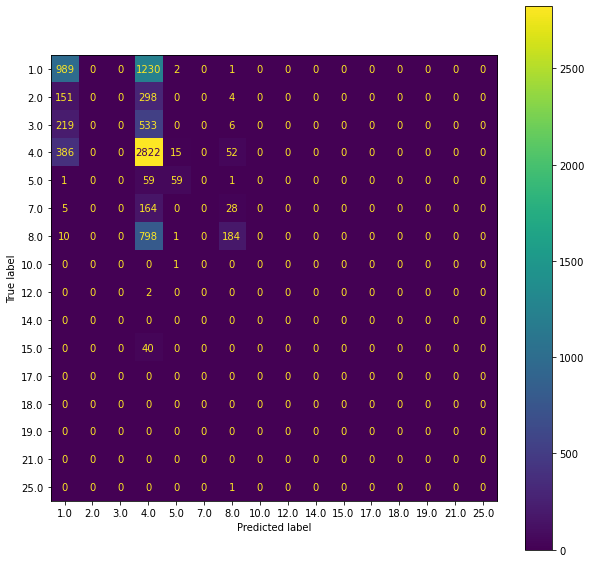

In [14]:
cm = confusion_matrix(y_test, predictions, labels=cla.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cla.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Classifing current weather conditions
based on the weather of the last 5 hours and using LSTM
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [18]:
df = df_weather[['time_now','temp_now','rhum_now','pres_now','coco_now']]
df

,time_now,temp_now,rhum_now,pres_now,coco_now
16079,2018-11-02 00:00:00,9.3,89.0,1017.4,4.0
16080,2018-11-02 01:00:00,7.8,91.0,1018.0,3.0
16081,2018-11-02 02:00:00,7.2,94.0,1018.3,2.0
16082,2018-11-02 03:00:00,7.0,93.0,1018.6,1.0
16083,2018-11-02 04:00:00,7.0,92.0,1019.5,4.0
...,...,...,...,...,...
51137,2022-11-01 18:00:00,10.6,82.0,1021.9,1.0
51138,2022-11-01 19:00:00,11.4,81.0,1022.1,1.0
51139,2022-11-01 20:00:00,10.9,83.0,1022.0,1.0
51140,2022-11-01 21:00:00,10.3,87.0,1022.6,1.0


In [19]:
values = df.drop(['time_now'],axis=1).values
scaler = MinMaxScaler(feature_range=(0,1))
#scaled = scaler.fit_transform(values)

In [20]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [21]:
reframed = series_to_supervised(df.drop('time_now',axis=1), 5)

In [22]:
scaled = scaler.fit_transform(reframed)

In [23]:
import json
from sklearn.preprocessing import MinMaxScaler


# Extract the relevant parameters of the scaler
params = {'min': scaler.data_min_.tolist(),
          'range': scaler.data_range_.tolist()}

# Save the parameters as JSON
filename = 'minmax_scaler1.json'
with open(filename, 'w') as f:
    json.dump(params, f)

print(f"MinMaxScaler saved to {filename}")



MinMaxScaler saved to minmax_scaler1.json


In [24]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
16084,9.3,89.0,1017.4,4.0,7.8,91.0,1018.0,3.0,7.2,94.0,1018.3,2.0,7.0,93.0,1018.6,1.0,7.0,92.0,1019.5,4.0,6.7,94.0,1020.0,1.0
16085,7.8,91.0,1018.0,3.0,7.2,94.0,1018.3,2.0,7.0,93.0,1018.6,1.0,7.0,92.0,1019.5,4.0,6.7,94.0,1020.0,1.0,5.5,97.0,1020.7,1.0
16086,7.2,94.0,1018.3,2.0,7.0,93.0,1018.6,1.0,7.0,92.0,1019.5,4.0,6.7,94.0,1020.0,1.0,5.5,97.0,1020.7,1.0,6.3,94.0,1021.6,1.0
16087,7.0,93.0,1018.6,1.0,7.0,92.0,1019.5,4.0,6.7,94.0,1020.0,1.0,5.5,97.0,1020.7,1.0,6.3,94.0,1021.6,1.0,8.3,85.0,1022.5,1.0
16088,7.0,92.0,1019.5,4.0,6.7,94.0,1020.0,1.0,5.5,97.0,1020.7,1.0,6.3,94.0,1021.6,1.0,8.3,85.0,1022.5,1.0,9.7,79.0,1022.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51137,17.2,61.0,1020.0,2.0,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0
51138,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0
51139,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0
51140,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0,10.3,87.0,1022.6,1.0


In [25]:
reframed = pd.DataFrame(scaled, columns=reframed.columns)

In [26]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
0,0.427203,0.872093,0.568149,0.125000,0.398467,0.895349,0.576758,0.083333,0.386973,0.930233,0.581062,0.041667,0.383142,0.918605,0.585366,0.000,0.383142,0.906977,0.598278,0.125,0.377395,0.930233,0.605452,0.000
1,0.398467,0.895349,0.576758,0.083333,0.386973,0.930233,0.581062,0.041667,0.383142,0.918605,0.585366,0.000000,0.383142,0.906977,0.598278,0.125,0.377395,0.930233,0.605452,0.000,0.354406,0.965116,0.615495,0.000
2,0.386973,0.930233,0.581062,0.041667,0.383142,0.918605,0.585366,0.000000,0.383142,0.906977,0.598278,0.125000,0.377395,0.930233,0.605452,0.000,0.354406,0.965116,0.615495,0.000,0.369732,0.930233,0.628407,0.000
3,0.383142,0.918605,0.585366,0.000000,0.383142,0.906977,0.598278,0.125000,0.377395,0.930233,0.605452,0.000000,0.354406,0.965116,0.615495,0.000,0.369732,0.930233,0.628407,0.000,0.408046,0.825581,0.641320,0.000
4,0.383142,0.906977,0.598278,0.125000,0.377395,0.930233,0.605452,0.000000,0.354406,0.965116,0.615495,0.000000,0.369732,0.930233,0.628407,0.000,0.408046,0.825581,0.641320,0.000,0.434866,0.755814,0.645624,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35047,0.578544,0.546512,0.605452,0.041667,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000,0.505747,0.651163,0.624103,0.000,0.452107,0.790698,0.632712,0.000
35048,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000,0.452107,0.790698,0.632712,0.000,0.467433,0.779070,0.635581,0.000
35049,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000,0.467433,0.779070,0.635581,0.000,0.457854,0.802326,0.634146,0.000
35050,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000,0.457854,0.802326,0.634146,0.000,0.446360,0.848837,0.642755,0.000


In [27]:
# split into train and test sets
values = reframed.values
n_train_hours = 365* 3 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 23) (26280,) (8772, 1, 23) (8772,)


In [28]:
train_X[1]

array([[0.39846743, 0.89534884, 0.57675753, 0.08333333, 0.38697318,
        0.93023256, 0.58106169, 0.04166667, 0.38314176, 0.91860465,
        0.58536585, 0.        , 0.38314176, 0.90697674, 0.59827834,
        0.125     , 0.37739464, 0.93023256, 0.60545194, 0.        ,
        0.35440613, 0.96511628, 0.61549498]])

Epoch 1/50
365/365 - 10s - loss: 0.0525 - val_loss: 0.0415 - 10s/epoch - 28ms/step
Epoch 2/50
365/365 - 2s - loss: 0.0406 - val_loss: 0.0371 - 2s/epoch - 7ms/step
Epoch 3/50
365/365 - 2s - loss: 0.0383 - val_loss: 0.0349 - 2s/epoch - 6ms/step
Epoch 4/50
365/365 - 2s - loss: 0.0370 - val_loss: 0.0344 - 2s/epoch - 6ms/step
Epoch 5/50
365/365 - 2s - loss: 0.0362 - val_loss: 0.0346 - 2s/epoch - 6ms/step
Epoch 6/50
365/365 - 2s - loss: 0.0366 - val_loss: 0.0339 - 2s/epoch - 6ms/step
Epoch 7/50
365/365 - 2s - loss: 0.0350 - val_loss: 0.0344 - 2s/epoch - 6ms/step
Epoch 8/50
365/365 - 2s - loss: 0.0362 - val_loss: 0.0344 - 2s/epoch - 6ms/step
Epoch 9/50
365/365 - 2s - loss: 0.0353 - val_loss: 0.0352 - 2s/epoch - 6ms/step
Epoch 10/50
365/365 - 2s - loss: 0.0357 - val_loss: 0.0351 - 2s/epoch - 5ms/step
Epoch 11/50
365/365 - 2s - loss: 0.0354 - val_loss: 0.0347 - 2s/epoch - 6ms/step
Epoch 12/50
365/365 - 2s - loss: 0.0342 - val_loss: 0.0333 - 2s/epoch - 6ms/step
Epoch 13/50
365/365 - 2s - loss: 0

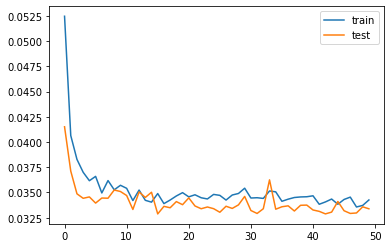

In [29]:
#designing the network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,851
Trainable params: 14,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
pred = model.predict(test_X)
pred

275/275 [==============================] - 3s 5ms/step


array([[ 0.290692  ],
       [ 0.2885246 ],
       [ 0.28870812],
       ...,
       [-0.0007225 ],
       [-0.0012878 ],
       [-0.00122436]], dtype=float32)

In [32]:
print(test_X)

[[[0.51532567 0.8372093  0.34863702 ... 0.46360153 0.95348837 0.38020086]]

 [[0.50957854 0.89534884 0.35868006 ... 0.45785441 0.93023256 0.38593974]]

 [[0.48659004 0.8255814  0.37302726 ... 0.45019157 0.95348837 0.39167862]]

 ...

 [[0.57279693 0.54651163 0.61119082 ... 0.45785441 0.80232558 0.63414634]]

 [[0.5440613  0.56976744 0.61549498 ... 0.44636015 0.84883721 0.64275466]]

 [[0.50574713 0.65116279 0.6241033  ... 0.44252874 0.86046512 0.64705882]]]


In [33]:
v = np.array([test_X[45]])

In [34]:
v

array([[[0.39846743, 0.90697674, 0.38163558, 0.125     , 0.38505747,
         0.95348837, 0.37446198, 0.08333333, 0.38122605, 0.95348837,
         0.36441894, 0.125     , 0.35057471, 0.98837209, 0.36728838,
         0.16666667, 0.36206897, 0.97674419, 0.35724534, 0.125     ,
         0.35632184, 0.95348837, 0.34863702]]])

In [35]:
model.predict(v)

1/1 [==============================] - 0s 81ms/step


array([[0.12470626]], dtype=float32)

In [36]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X

array([[0.51532567, 0.8372093 , 0.34863702, ..., 0.46360153, 0.95348837,
        0.38020086],
       [0.50957854, 0.89534884, 0.35868006, ..., 0.45785441, 0.93023256,
        0.38593974],
       [0.48659004, 0.8255814 , 0.37302726, ..., 0.45019157, 0.95348837,
        0.39167862],
       ...,
       [0.57279693, 0.54651163, 0.61119082, ..., 0.45785441, 0.80232558,
        0.63414634],
       [0.5440613 , 0.56976744, 0.61549498, ..., 0.44636015, 0.84883721,
        0.64275466],
       [0.50574713, 0.65116279, 0.6241033 , ..., 0.44252874, 0.86046512,
        0.64705882]])

In [37]:
inv_yhat = concatenate((test_X, pred), axis=1)
inv_yhat

array([[ 5.15325670e-01,  8.37209302e-01,  3.48637016e-01, ...,
         9.53488372e-01,  3.80200861e-01,  2.90692002e-01],
       [ 5.09578544e-01,  8.95348837e-01,  3.58680057e-01, ...,
         9.30232558e-01,  3.85939742e-01,  2.88524598e-01],
       [ 4.86590038e-01,  8.25581395e-01,  3.73027260e-01, ...,
         9.53488372e-01,  3.91678623e-01,  2.88708121e-01],
       ...,
       [ 5.72796935e-01,  5.46511628e-01,  6.11190818e-01, ...,
         8.02325581e-01,  6.34146341e-01, -7.22499331e-04],
       [ 5.44061303e-01,  5.69767442e-01,  6.15494978e-01, ...,
         8.48837209e-01,  6.42754663e-01, -1.28780375e-03],
       [ 5.05747126e-01,  6.51162791e-01,  6.24103300e-01, ...,
         8.60465116e-01,  6.47058824e-01, -1.22436020e-03]])

In [40]:
test_scaled = pd.DataFrame(inv_yhat,columns=['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)','pred'])
test_scaled

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),pred
0,0.515326,0.837209,0.348637,0.125000,0.509579,0.895349,0.358680,0.291667,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.290692
1,0.509579,0.895349,0.358680,0.291667,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.288525
2,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.288708
3,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.250000,0.455939,0.895349,0.398852,0.247632
4,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.250000,0.455939,0.895349,0.398852,0.291667,0.457854,0.848837,0.394548,0.286614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.578544,0.546512,0.605452,0.041667,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000600
8768,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,-0.000843
8769,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000000,0.457854,0.802326,0.634146,-0.000722
8770,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000000,0.457854,0.802326,0.634146,0.000000,0.446360,0.848837,0.642755,-0.001288


In [41]:
test = scaler.inverse_transform(test_scaled)
test

array([[1.39000000e+01, 8.60000000e+01, 1.00210000e+03, ...,
        9.60000000e+01, 1.00430000e+03, 7.97660804e+00],
       [1.36000000e+01, 9.10000000e+01, 1.00280000e+03, ...,
        9.40000000e+01, 1.00470000e+03, 7.92459035e+00],
       [1.24000000e+01, 8.50000000e+01, 1.00380000e+03, ...,
        9.60000000e+01, 1.00510000e+03, 7.92899489e+00],
       ...,
       [1.69000000e+01, 6.10000000e+01, 1.02040000e+03, ...,
        8.30000000e+01, 1.02200000e+03, 9.82660016e-01],
       [1.54000000e+01, 6.30000000e+01, 1.02070000e+03, ...,
        8.70000000e+01, 1.02260000e+03, 9.69092710e-01],
       [1.34000000e+01, 7.00000000e+01, 1.02130000e+03, ...,
        8.80000000e+01, 1.02290000e+03, 9.70615355e-01]])

In [42]:
print(test[1])

[  13.6          91.         1002.8           8.           12.4
   85.         1003.8           8.           11.4          92.
 1003.            8.           11.2          96.         1003.8
    8.           11.2          96.         1004.3           8.
   10.9          94.         1004.7           7.92459035]


In [43]:
test = pd.DataFrame(test, columns= test_scaled.columns) 

In [44]:
test

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),pred
0,13.9,86.0,1002.1,4.0,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,7.976608
1,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,7.924590
2,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.928995
3,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,6.943170
4,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,8.0,10.9,87.0,1005.3,7.878745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,1020.0,2.0,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.014390
8768,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,0.979776
8769,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,0.982660
8770,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0,10.3,87.0,1022.6,0.969093


In [45]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X, test_y), axis=1)
inv_y 

array([[0.51532567, 0.8372093 , 0.34863702, ..., 0.95348837, 0.38020086,
        0.29166667],
       [0.50957854, 0.89534884, 0.35868006, ..., 0.93023256, 0.38593974,
        0.29166667],
       [0.48659004, 0.8255814 , 0.37302726, ..., 0.95348837, 0.39167862,
        0.25      ],
       ...,
       [0.57279693, 0.54651163, 0.61119082, ..., 0.80232558, 0.63414634,
        0.        ],
       [0.5440613 , 0.56976744, 0.61549498, ..., 0.84883721, 0.64275466,
        0.        ],
       [0.50574713, 0.65116279, 0.6241033 , ..., 0.86046512, 0.64705882,
        0.125     ]])

In [47]:
inv_y = pd.DataFrame(inv_y, columns=['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 
       'var1(t)', 'var2(t)', 'var3(t)','actual'])

In [48]:
inv_y

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),actual
0,0.515326,0.837209,0.348637,0.125000,0.509579,0.895349,0.358680,0.291667,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667
1,0.509579,0.895349,0.358680,0.291667,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667
2,0.486590,0.825581,0.373027,0.291667,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.250000
3,0.467433,0.906977,0.361549,0.291667,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.250000,0.455939,0.895349,0.398852,0.291667
4,0.463602,0.953488,0.373027,0.291667,0.463602,0.953488,0.380201,0.291667,0.457854,0.930233,0.385940,0.291667,0.450192,0.953488,0.391679,0.250000,0.455939,0.895349,0.398852,0.291667,0.457854,0.848837,0.394548,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.578544,0.546512,0.605452,0.041667,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000
8768,0.588123,0.534884,0.606887,0.000000,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000000
8769,0.572797,0.546512,0.611191,0.083333,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000000,0.457854,0.802326,0.634146,0.000000
8770,0.544061,0.569767,0.615495,0.000000,0.505747,0.651163,0.624103,0.000000,0.452107,0.790698,0.632712,0.000000,0.467433,0.779070,0.635581,0.000000,0.457854,0.802326,0.634146,0.000000,0.446360,0.848837,0.642755,0.000000


In [49]:
test_actual = scaler.inverse_transform(inv_y)
test_actual

array([[1.3900e+01, 8.6000e+01, 1.0021e+03, ..., 9.6000e+01, 1.0043e+03,
        8.0000e+00],
       [1.3600e+01, 9.1000e+01, 1.0028e+03, ..., 9.4000e+01, 1.0047e+03,
        8.0000e+00],
       [1.2400e+01, 8.5000e+01, 1.0038e+03, ..., 9.6000e+01, 1.0051e+03,
        7.0000e+00],
       ...,
       [1.6900e+01, 6.1000e+01, 1.0204e+03, ..., 8.3000e+01, 1.0220e+03,
        1.0000e+00],
       [1.5400e+01, 6.3000e+01, 1.0207e+03, ..., 8.7000e+01, 1.0226e+03,
        1.0000e+00],
       [1.3400e+01, 7.0000e+01, 1.0213e+03, ..., 8.8000e+01, 1.0229e+03,
        4.0000e+00]])

In [50]:
test_actual = pd.DataFrame(test_actual, columns = inv_y.columns)
test_actual

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),actual
0,13.9,86.0,1002.1,4.0,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0
1,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0
2,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0
3,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,8.0
4,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,8.0,10.9,87.0,1005.3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,1020.0,2.0,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0
8768,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0
8769,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0
8770,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0,10.3,87.0,1022.6,1.0


In [51]:
test['actual'] = test_actual.actual
test

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),pred,actual
0,13.9,86.0,1002.1,4.0,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,7.976608,8.0
1,13.6,91.0,1002.8,8.0,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,7.924590,8.0
2,12.4,85.0,1003.8,8.0,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.928995,7.0
3,11.4,92.0,1003.0,8.0,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,6.943170,8.0
4,11.2,96.0,1003.8,8.0,11.2,96.0,1004.3,8.0,10.9,94.0,1004.7,8.0,10.5,96.0,1005.1,7.0,10.8,91.0,1005.6,8.0,10.9,87.0,1005.3,7.878745,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,1020.0,2.0,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.014390,1.0
8768,17.7,60.0,1020.1,1.0,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,0.979776,1.0
8769,16.9,61.0,1020.4,3.0,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,0.982660,1.0
8770,15.4,63.0,1020.7,1.0,13.4,70.0,1021.3,1.0,10.6,82.0,1021.9,1.0,11.4,81.0,1022.1,1.0,10.9,83.0,1022.0,1.0,10.3,87.0,1022.6,0.969093,1.0


In [65]:
test.sample(20)

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),pred,actual,pred_rounded
7655,14.3,80.0,1011.0,4.0,14.3,78.0,1011.0,4.0,15.2,71.0,1011.2,4.0,15.0,67.0,1011.4,4.0,15.3,66.0,1011.7,4.0,16.5,59.0,1011.4,3.983773,8.0,4.0
8072,15.6,60.0,1027.2,4.0,16.3,61.0,1027.0,4.0,15.8,59.0,1026.8,4.0,14.5,67.0,1026.6,4.0,12.1,80.0,1026.6,2.0,10.7,86.0,1026.5,2.038212,3.0,2.0
3127,3.8,48.0,1021.1,4.0,5.2,44.0,1021.1,1.0,6.1,41.0,1021.1,2.0,7.4,39.0,1020.6,1.0,9.1,37.0,1020.4,1.0,10.0,35.0,1019.5,0.976010,1.0,1.0
8658,12.8,96.0,1023.6,4.0,13.7,95.0,1023.6,4.0,15.1,89.0,1023.3,4.0,15.2,88.0,1022.8,4.0,16.5,80.0,1022.0,8.0,15.1,83.0,1022.7,7.781877,4.0,8.0
1836,1.6,84.0,1028.9,15.0,2.3,84.0,1028.7,4.0,2.9,84.0,1028.3,4.0,3.0,83.0,1029.4,7.0,2.9,84.0,1029.7,7.0,2.5,90.0,1030.6,6.858210,8.0,7.0
2281,6.7,79.0,1016.3,8.0,6.7,80.0,1016.5,4.0,6.6,83.0,1016.4,4.0,6.5,86.0,1016.4,4.0,6.5,86.0,1016.6,4.0,6.6,86.0,1016.7,3.964696,8.0,4.0
144,4.5,99.0,1026.2,4.0,4.6,98.0,1025.5,4.0,4.6,96.0,1024.8,4.0,4.2,95.0,1024.6,4.0,4.6,95.0,1023.9,4.0,4.9,94.0,1023.2,3.910936,4.0,4.0
2323,3.2,85.0,1024.6,1.0,2.5,88.0,1024.5,1.0,2.7,87.0,1024.2,1.0,3.7,82.0,1023.9,4.0,4.9,77.0,1023.1,4.0,4.8,78.0,1022.6,3.884274,4.0,4.0
2471,-1.3,95.0,1036.1,1.0,-1.0,93.0,1035.8,1.0,-2.4,96.0,1035.6,1.0,-3.1,97.0,1035.4,1.0,-3.1,97.0,1034.8,1.0,-4.0,96.0,1034.5,0.834533,1.0,1.0
1346,3.4,99.0,1005.7,4.0,3.8,98.0,1005.2,4.0,4.5,99.0,1005.0,8.0,5.7,100.0,1004.7,8.0,6.0,99.0,1004.2,8.0,6.1,99.0,1003.9,7.940494,8.0,8.0


In [63]:
row_list = test.loc[1959, :].values.flatten().tolist()

In [64]:
print(row_list)

[4.299999999999999, 72.0, 1033.9, 4.0, 4.299999999999999, 73.0, 1033.6, 4.0, 4.200000000000001, 73.0, 1033.7, 4.0, 4.200000000000001, 74.0, 1033.8, 8.0, 3.999999999999999, 76.0, 1034.0, 8.0, 3.8999999999999986, 78.0, 1034.2, 7.870649337768556, 8.0, 8.0]


<function matplotlib.pyplot.show(close=None, block=None)>

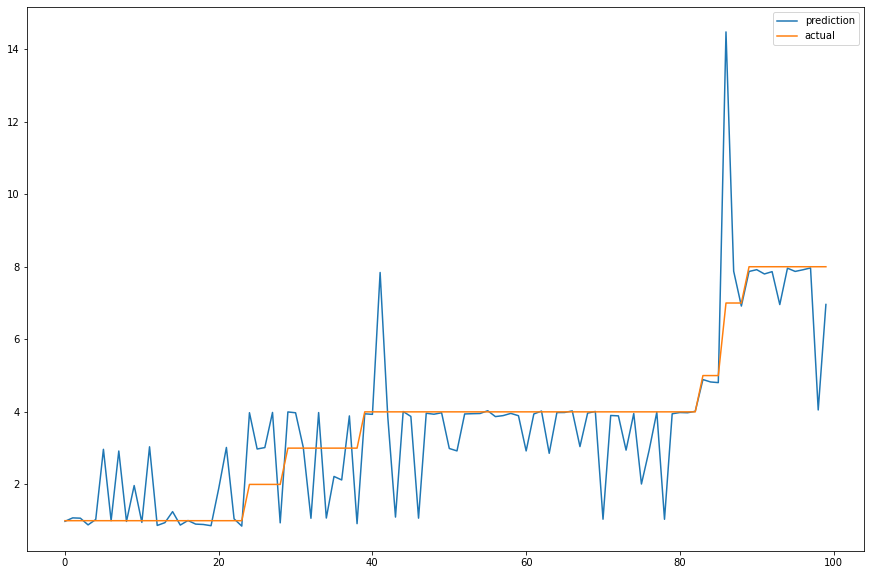

In [67]:
n = 100
smpl = test.sample(n)
smpl=smpl.sort_values('actual')
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.plot([i for i in range(n)], smpl.pred,label = 'prediction')
plt.plot([i for i in range(n)], smpl.actual, label = 'actual')
plt.legend()
plt.show

In [55]:
# calculate rsme
rsme = sqrt(mean_squared_error(test_y,pred))

In [56]:
rsme

0.06656110352343468

In [57]:
test['pred_rounded'] = round(test.pred)

In [58]:
labels=['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11.0','12.0','13.0','14.0','15.0','16.0','18.0','19.0','20.0','21.0','22.0','23.0','24.0','25.0']

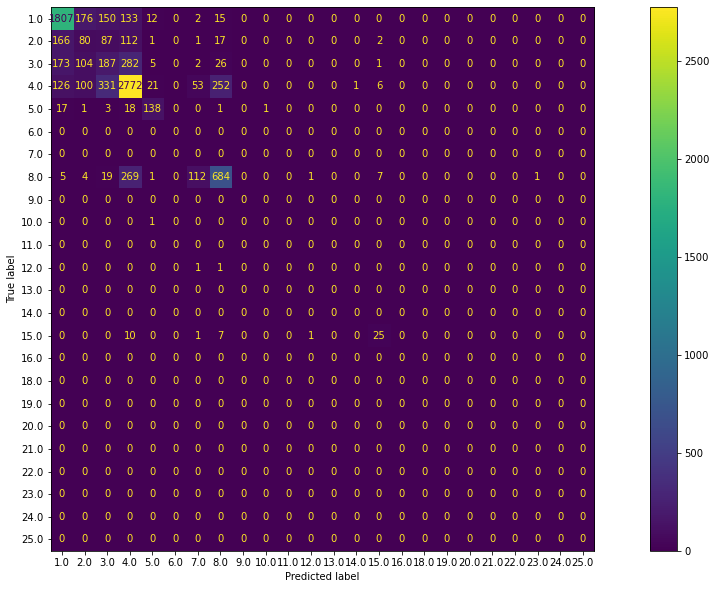

In [59]:
cm = confusion_matrix(test.actual.astype('str'), test.pred_rounded.astype('str'), labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(20,10))
disp.plot(ax=ax)

In [60]:
tfjs_target_dir = '/Users/dennisknierim/Dokumente/wetterdaten_mannheim/weekly/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

In [39]:
model.save('.')

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [41]:
tfjs.converters.save_keras_model(model, '.')

In [49]:
model.save_weights('.')

In [115]:
tensorflow.saved_model.save(model, '/Users/dennisknierim/Dokumente/wetterdaten_mannheim/weekly')

INFO:tensorflow:Assets written to: /Users/dennisknierim/Dokumente/wetterdaten_mannheim/weekly/assets


INFO:tensorflow:Assets written to: /Users/dennisknierim/Dokumente/wetterdaten_mannheim/weekly/assets


In [114]:
!pwd

/Users/dennisknierim/Dokumente/wetterdaten_mannheim/weekly
